# 1. Importing Data and Packages :

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score)
from gensim.utils import simple_preprocess
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

In [2]:
path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")
df = pd.read_csv(path + "/Tweets.csv")

# 2. Data Exploration :

In [3]:
print("Résumé de la DataFrame : \n")
print(df.info())

print("\n Valeur manquante dans la DataFrame : \n")
display(df.isnull().sum())

print("\n Notre DataFrame : \n")
df.head(10)

Résumé de la DataFrame : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 146

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


 Notre DataFrame : 



,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)



 Les valeurs de la variable airline_sentiment : 

[1 2 0]

 Nombre de tweets positifs, neutres et négatifs : 



C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\3490647521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[df1['airline_sentiment']=='negative', 'airline_sentiment']=0
C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\3490647521.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[df1['airline_sentiment']=='neutral', 'airline_sentiment']=1
C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\3490647521.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


 Visualisation des tweets : 



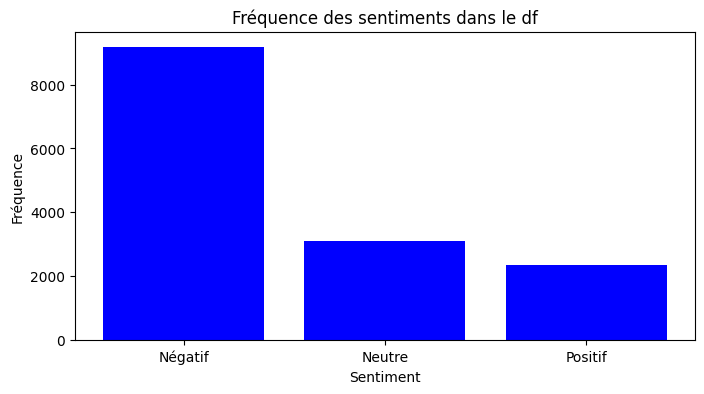

Dataset sélectionné : 



,airline_sentiment,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials t...
2,1,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,2,@AmericanAir thank you we got on a different f...
14636,0,@AmericanAir leaving over 20 minutes Late Flig...
14637,1,@AmericanAir Please bring American Airlines to...
14638,0,"@AmericanAir you have my money, you change my ..."


In [4]:
# Vu que on essaye de classifier les tweets en positif, neutre ou négatif,
# On va garder que ces 2 variables : airline_sentiment et text
df1 = df[['airline_sentiment', 'text']]


df1.loc[df1['airline_sentiment']=='negative', 'airline_sentiment']=0
df1.loc[df1['airline_sentiment']=='neutral', 'airline_sentiment']=1
df1.loc[df1['airline_sentiment']=='positive', 'airline_sentiment']=2
df1['airline_sentiment'] = pd.to_numeric(df1['airline_sentiment'])
print("\n Les valeurs de la variable airline_sentiment : \n")
print(df1['airline_sentiment'].unique())


# On va calculer le nombre de tweets positifs et négatifs
target_count = df["airline_sentiment"].value_counts()
print("\n Nombre de tweets positifs, neutres et négatifs : \n")
display(target_count)
# Présentation graphique :
print("\n Visualisation des tweets : \n")
plt.figure(figsize=(8,4))
plt.bar(target_count.index, target_count.values, color="blue")
plt.title("Fréquence des sentiments dans le df")
plt.xlabel("Sentiment")
plt.ylabel("Fréquence")
plt.xticks(target_count.index, ["Négatif", "Neutre", "Positif"]) 
plt.show()

print("Dataset sélectionné : \n")
display(df1)

# 3. Data Pre-processing :

In [5]:
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

def nettoyage_texte(text):
    if not isinstance(text, str):  # Vérification si le texte est valide
        return ""

    # Supprimer les caractères spéciaux sauf lettres et espaces
    text = re.sub(r"[^\w\s]", "", text)

    # Supprimer les chiffres
    text = re.sub(r"\d+", "", text)

    # Conversion en minuscule
    text = text.lower()

    # Suppression des URLs, mentions, hashtags et autres artefacts
    text = re.sub(r"http[s]?://\S+", "", text)
    text = re.sub(r"www\.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#[A-Za-z0-9_]+", "", text)

    # Supprimer les espaces supplémentaires
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenisation
    tokens = word_tokenize(text)

    # Suppression des mots vides (stopwords)
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Relier les tokens nettoyés en une seule chaîne
    texte_nettoye = " ".join(tokens)

    return texte_nettoye

## Différence entre `simple_preprocess` (Gensim) et `nettoyage_texte` :  

La fonction **`simple_preprocess`** de Gensim est une préparation basique de texte qui :  
- Convertit en minuscules,  
- Supprime les accents (ex. "é" → "e"),  
- Tokenise le texte en mots de longueur minimale paramétrable.  
Elle est rapide et légère, mais ne gère pas les chiffres, les stopwords, ou les artefacts (URLs, hashtags).  

La fonction **`nettoyage_texte`** est une pipeline complète incluant :  
1. **Nettoyage avancé** : suppression des caractères spéciaux, chiffres, URLs, hashtags, mentions.  
2. **Tokenisation fine** avec `nltk.word_tokenize`.  
3. **Filtrage des stopwords** (mots vides comme "the", "and").  
4. **Normalisation** (minuscules, espaces).  

In [6]:
# Appliquer le nettoyage : fonction 'nettoyage_texte' qu'on a créé
print(" Dataset séléctionnée nettoyée : \n")
df1['clean_text']=df1['text'].apply(nettoyage_texte)

# Appliquer le nettoyage : fonction 'simple_preprocess' de gensim
df1['clean_text_1'] = df1['text'].apply(lambda x: simple_preprocess(str(x), deacc=True))
display(df1)

 Dataset séléctionnée nettoyée : 



C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\1437620951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['clean_text']=df1['text'].apply(nettoyage_texte)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\1437620951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['clean_text_1'] = df1['text'].apply(lambda x: simple_preprocess(str(x), deacc=True))


,airline_sentiment,text,clean_text,clean_text_1
0,1,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said,"[virginamerica, what, dhepburn, said]"
1,2,@VirginAmerica plus you've added commercials t...,virginamerica plus youve added commercials exp...,"[virginamerica, plus, you, ve, added, commerci..."
2,1,@VirginAmerica I didn't today... Must mean I n...,virginamerica didnt today must mean need take ...,"[virginamerica, didn, today, must, mean, need,..."
3,0,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...,"[virginamerica, it, really, aggressive, to, bl..."
4,0,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing,"[virginamerica, and, it, really, big, bad, thi..."
...,...,...,...,...
14635,2,@AmericanAir thank you we got on a different f...,americanair thank got different flight chicago,"[americanair, thank, you, we, got, on, differe..."
14636,0,@AmericanAir leaving over 20 minutes Late Flig...,americanair leaving minutes late flight warnin...,"[americanair, leaving, over, minutes, late, fl..."
14637,1,@AmericanAir Please bring American Airlines to...,americanair please bring american airlines bla...,"[americanair, please, bring, american, airline..."
14638,0,"@AmericanAir you have my money, you change my ...",americanair money change flight dont answer ph...,"[americanair, you, have, my, money, you, chang..."


In [7]:
# Cette partie est essentielle pour pouvoir travailler sur clean_text1, 
# afin de ne plus avoir une liste et de pouvoir travailler sur des phrases.
df1['clean_text_1_1'] = df1['clean_text_1'].apply(lambda x: ' '.join(x))
display(df1)

C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\631675815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['clean_text_1_1'] = df1['clean_text_1'].apply(lambda x: ' '.join(x))


,airline_sentiment,text,clean_text,clean_text_1,clean_text_1_1
0,1,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said,"[virginamerica, what, dhepburn, said]",virginamerica what dhepburn said
1,2,@VirginAmerica plus you've added commercials t...,virginamerica plus youve added commercials exp...,"[virginamerica, plus, you, ve, added, commerci...",virginamerica plus you ve added commercials to...
2,1,@VirginAmerica I didn't today... Must mean I n...,virginamerica didnt today must mean need take ...,"[virginamerica, didn, today, must, mean, need,...",virginamerica didn today must mean need to tak...
3,0,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...,"[virginamerica, it, really, aggressive, to, bl...",virginamerica it really aggressive to blast ob...
4,0,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing,"[virginamerica, and, it, really, big, bad, thi...",virginamerica and it really big bad thing abou...
...,...,...,...,...,...
14635,2,@AmericanAir thank you we got on a different f...,americanair thank got different flight chicago,"[americanair, thank, you, we, got, on, differe...",americanair thank you we got on different flig...
14636,0,@AmericanAir leaving over 20 minutes Late Flig...,americanair leaving minutes late flight warnin...,"[americanair, leaving, over, minutes, late, fl...",americanair leaving over minutes late flight n...
14637,1,@AmericanAir Please bring American Airlines to...,americanair please bring american airlines bla...,"[americanair, please, bring, american, airline...",americanair please bring american airlines to ...
14638,0,"@AmericanAir you have my money, you change my ...",americanair money change flight dont answer ph...,"[americanair, you, have, my, money, you, chang...",americanair you have my money you change my fl...


## 3.1. Visualisation avant nettoyage du text : 

In [8]:
# Récupération des tweets 
positifs_tweets = df1[df1['airline_sentiment'] == 2]
negatifs_tweets = df1[df1['airline_sentiment'] == 0]
neutres_tweets = df1[df1['airline_sentiment'] == 1]

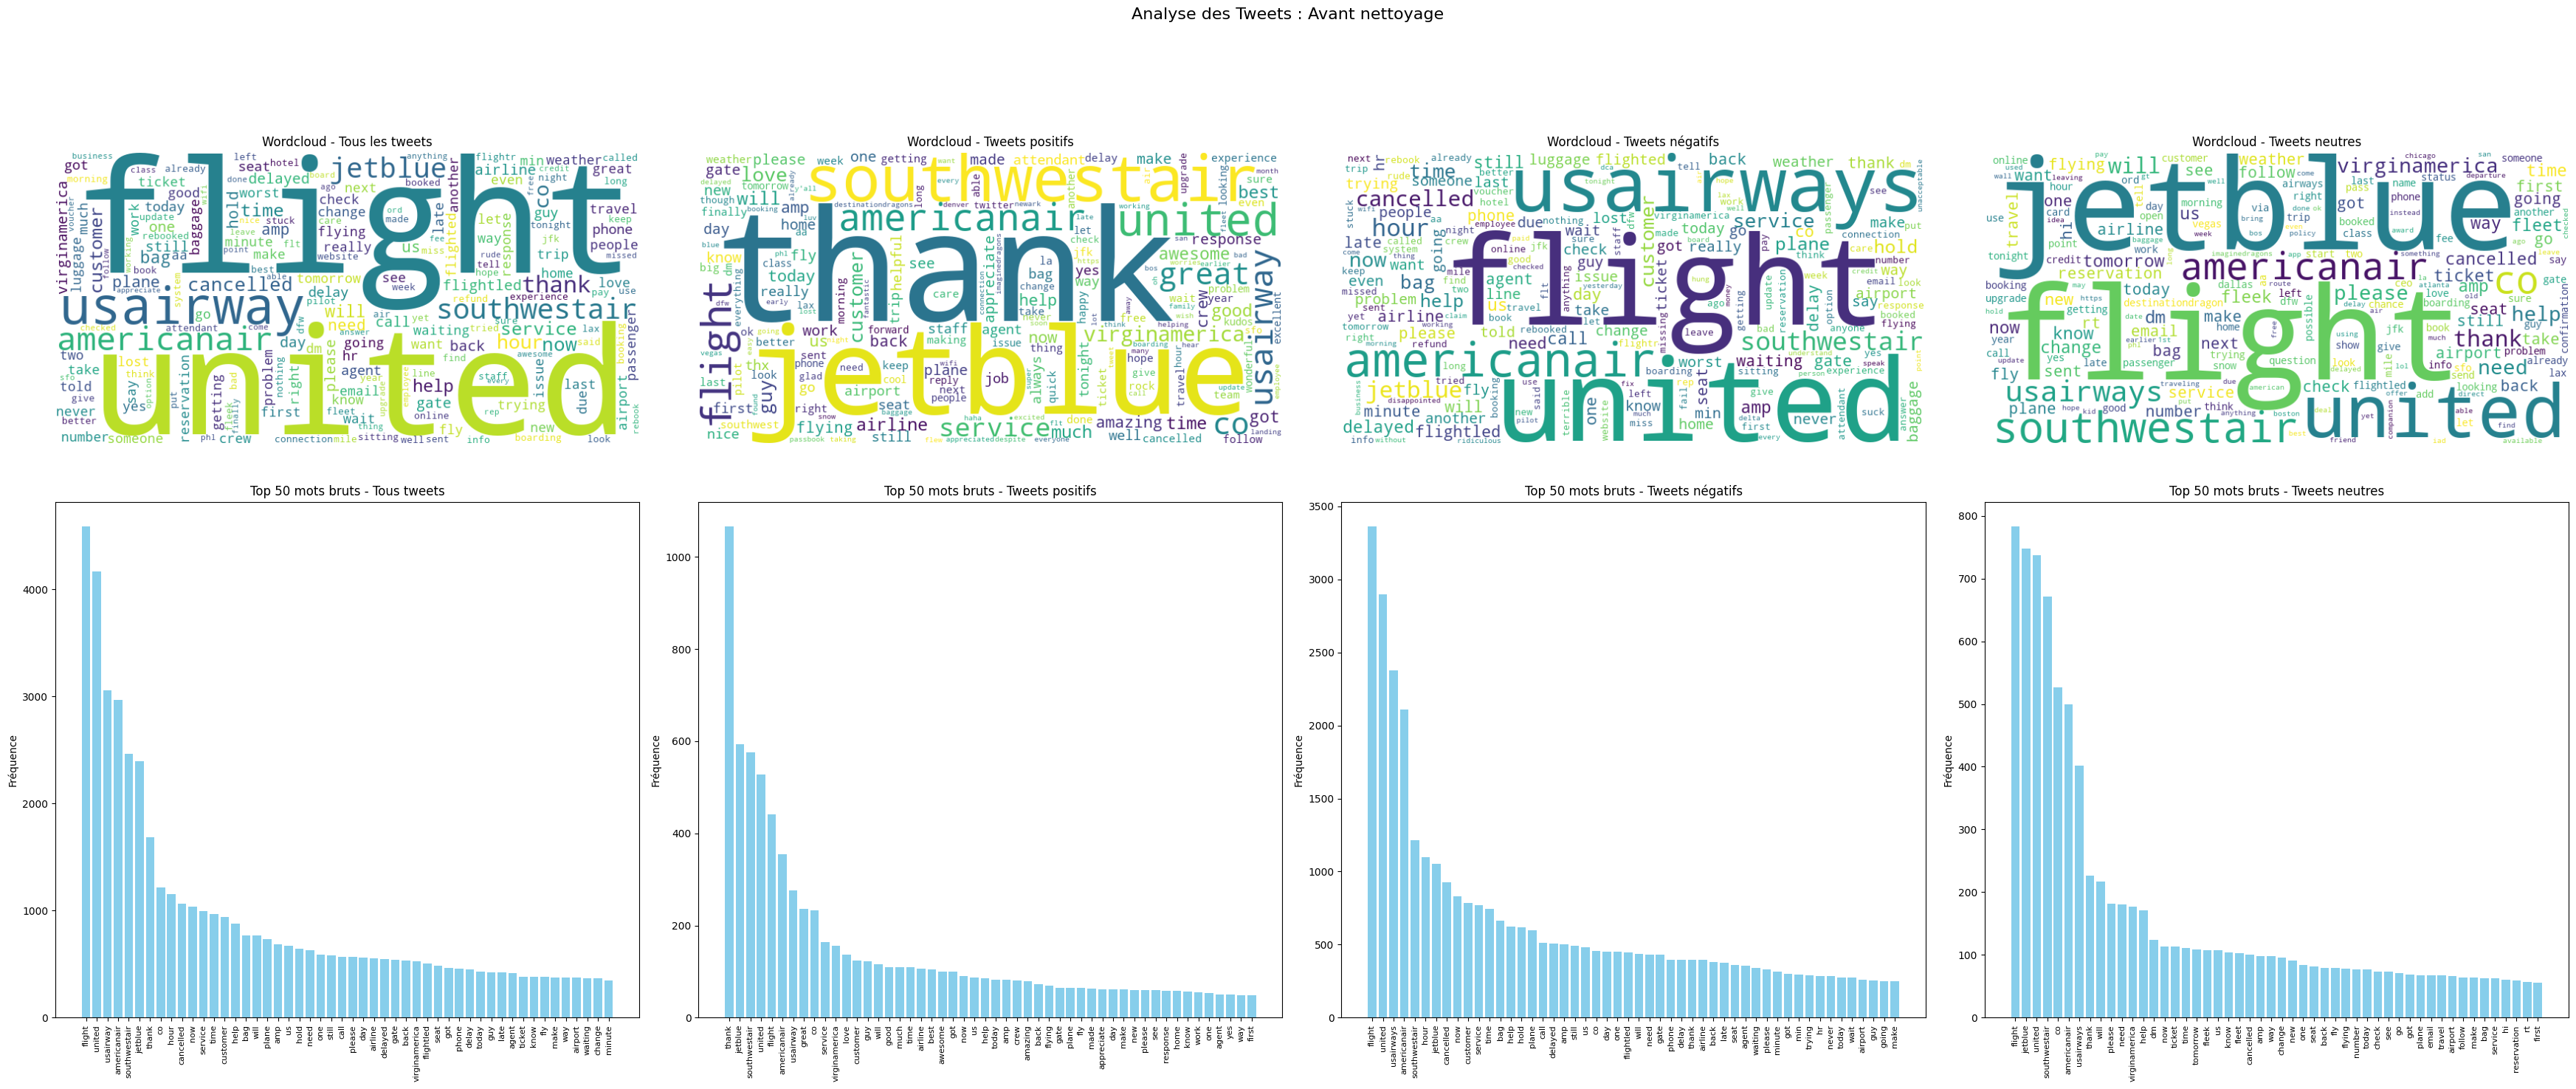

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Fonction pour concaténer les textes avec des options de filtrage
def concat_text(df, column, target_column="airline_sentiment", target_value=None):
    """Concatène les textes d'une colonne avec option de filtrage sur une colonne cible"""
    if target_value is not None:
        mask = df[target_column] == target_value
        texts = df.loc[mask, column].dropna().astype(str).str.cat(sep=" ")
    else:
        texts = df[column].dropna().astype(str).str.cat(sep=" ")
    return texts.lower() if texts else ""

# Extraction des textes de différentes catégories
all_texts = concat_text(df1, "text")  
positif_text = concat_text(positifs_tweets, "text")  
negatif_text = concat_text(negatifs_tweets, "text")  
neutres_text = concat_text(neutres_tweets, "text")

# Configuration des paramètres WordCloud
WC_CONFIG = {
    "width": 800,
    "height": 400,
    "background_color": "white",
    "collocations": False,
    "regexp": r"\w[\w']+"
}

# Fonction pour générer un WordCloud
def generate_wordcloud(text):
    return WordCloud(**WC_CONFIG).generate(text) if text else None

# Génération des nuages de mots
all_wordcloud = generate_wordcloud(all_texts)
positif_wordcloud = generate_wordcloud(positif_text)
negatif_wordcloud = generate_wordcloud(negatif_text)
neutres_wordcloud = generate_wordcloud(neutres_text)

# Fonction pour extraire les mots les plus fréquents
def get_top_words(text, n=50):
    if not text:
        return [], []
    wc = WordCloud(**WC_CONFIG)
    processed_text = wc.process_text(text)
    sorted_words = sorted(processed_text.items(), key=lambda x: (-x[1], x[0]))[:n]
    return list(zip(*sorted_words)) if sorted_words else ([], [])

# Extraction des top mots
all_words, all_counts = get_top_words(all_texts)
positif_words, positif_counts = get_top_words(positif_text)
negatif_words, negatif_counts = get_top_words(negatif_text)
neutres_words, neutres_counts = get_top_words(neutres_text)

# Configuration des graphiques avec 4 colonnes pour inclure les tweets neutres
fig, axes = plt.subplots(2, 4, figsize=(35, 15))

# 1. WordCloud - Tous les tweets
if all_wordcloud:
    axes[0, 0].imshow(all_wordcloud, interpolation="bilinear")
axes[0, 0].set_title("Wordcloud - Tous les tweets", fontsize=12)
axes[0, 0].axis("off")

# 2. Top 50 mots bruts - Tous les tweets
if all_words:
    axes[1, 0].bar(all_words, all_counts, color='skyblue')
    axes[1, 0].set_title("Top 50 mots bruts - Tous tweets", fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1, 0].set_ylabel("Fréquence")

# 3. WordCloud - Tweets positifs
if positif_wordcloud:
    axes[0, 1].imshow(positif_wordcloud, interpolation="bilinear")
axes[0, 1].set_title("Wordcloud - Tweets positifs", fontsize=12)
axes[0, 1].axis("off")

# 4. Top 50 mots bruts - Tweets positifs
if positif_words:
    axes[1, 1].bar(positif_words, positif_counts, color='skyblue')
    axes[1, 1].set_title("Top 50 mots bruts - Tweets positifs", fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1, 1].set_ylabel("Fréquence")

# 5. WordCloud - Tweets négatifs
if negatif_wordcloud:
    axes[0, 2].imshow(negatif_wordcloud, interpolation="bilinear")
axes[0, 2].set_title("Wordcloud - Tweets négatifs", fontsize=12)
axes[0, 2].axis("off")

# 6. Top 50 mots bruts - Tweets négatifs
if negatif_words:
    axes[1, 2].bar(negatif_words, negatif_counts, color='skyblue')
    axes[1, 2].set_title("Top 50 mots bruts - Tweets négatifs", fontsize=12)
    axes[1, 2].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1, 2].set_ylabel("Fréquence")

# 7. WordCloud - Tweets neutres
if neutres_wordcloud:
    axes[0, 3].imshow(neutres_wordcloud, interpolation="bilinear")
axes[0, 3].set_title("Wordcloud - Tweets neutres", fontsize=12)
axes[0, 3].axis("off")

# 8. Top 50 mots bruts - Tweets neutres
if neutres_words:
    axes[1, 3].bar(neutres_words, neutres_counts, color='skyblue')
    axes[1, 3].set_title("Top 50 mots bruts - Tweets neutres", fontsize=12)
    axes[1, 3].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1, 3].set_ylabel("Fréquence")

# Ajustements finaux
plt.tight_layout()
plt.suptitle("Analyse des Tweets : Avant nettoyage", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

## 3.2. Visualisation aprés nettoyage du text : 

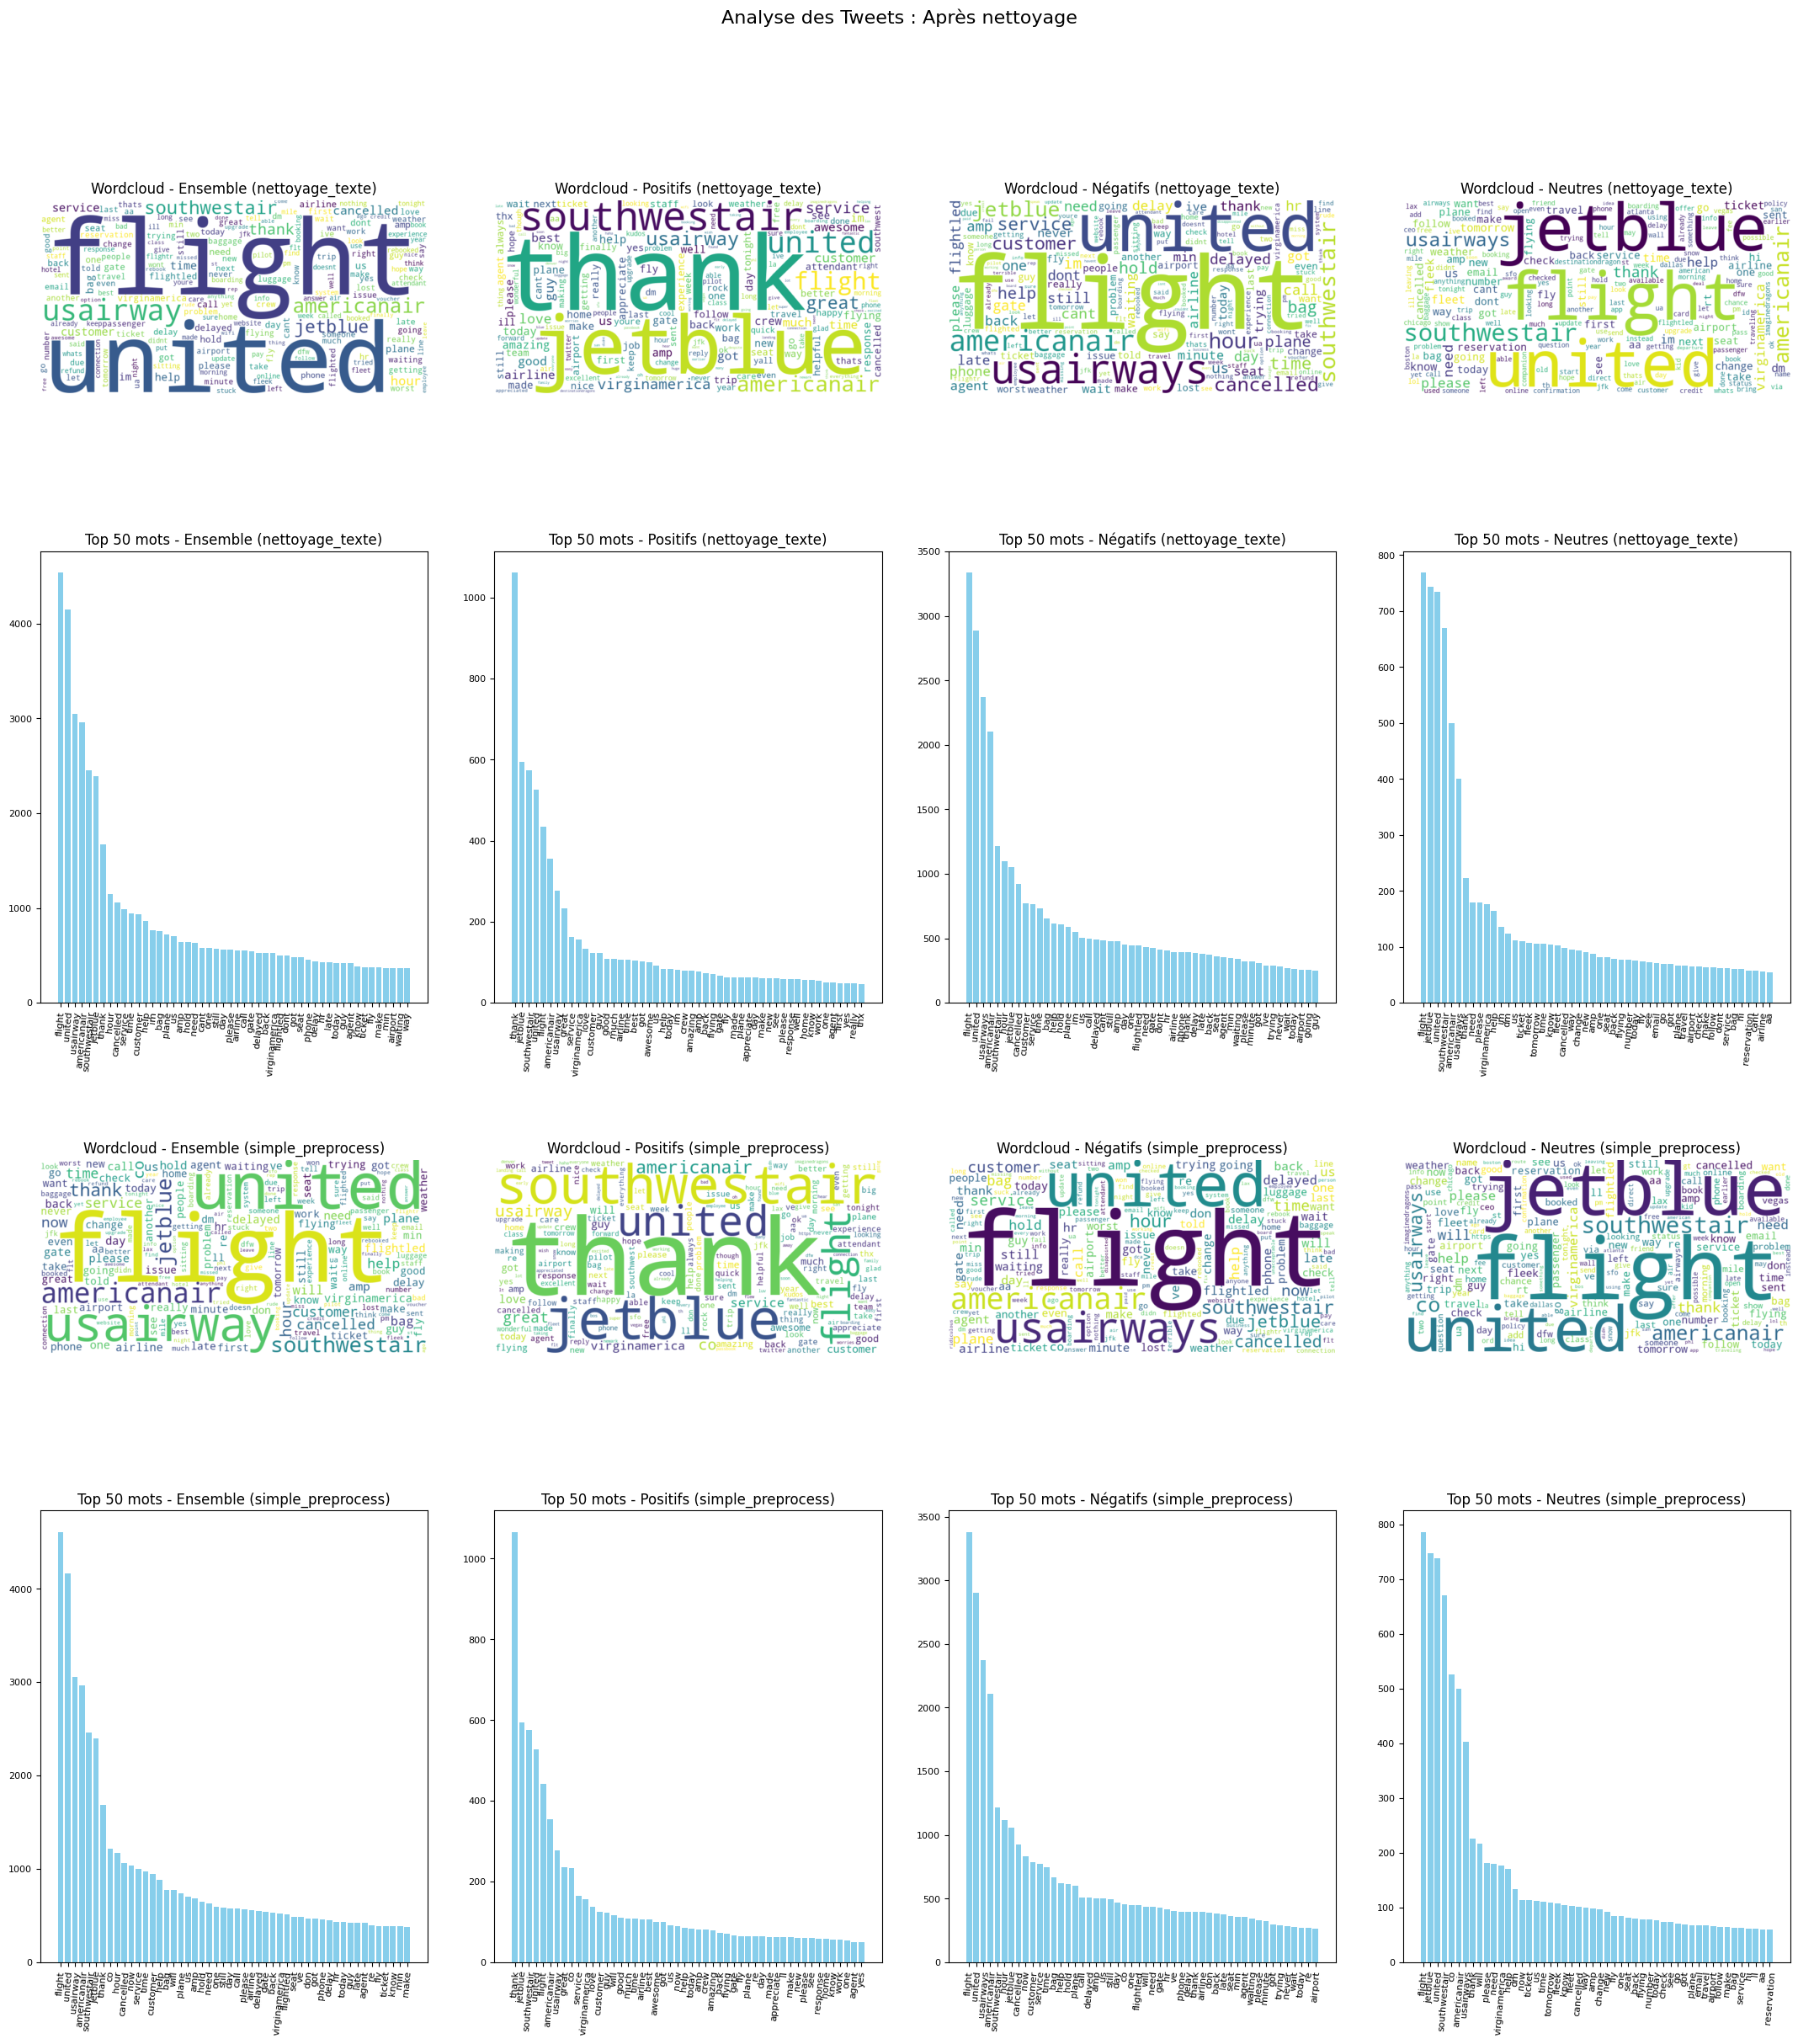

In [10]:
# Fonction de concaténation améliorée
def concat_text(df, column, target=None):
    """Concatène les textes avec filtrage optionnel"""
    if target is not None:
        texts = df.loc[df["airline_sentiment"] == target, column].dropna().astype(str).str.cat(sep=" ")
    else:
        texts = df[column].dropna().astype(str).str.cat(sep=" ")
    
    return texts.lower() if texts else ""

# Extraction des textes
all_texts = concat_text(df1, "clean_text")
positif_texts = concat_text(df1, "clean_text", 2)
negatif_texts = concat_text(df1, "clean_text", 0)
neutre_texts = concat_text(df1, "clean_text", 1)
all_texts1 = concat_text(df1, "clean_text_1_1")
positif_texts1 = concat_text(df1, "clean_text_1_1", 2)
negatif_texts1 = concat_text(df1, "clean_text_1_1", 0)
neutre_texts1 = concat_text(df1, "clean_text_1_1", 1)

# Configuration commune pour les WordClouds
WC_CONFIG = {
    "width": 800,
    "height": 400,
    "background_color": "white",
    "collocations": False,
    "regexp": r"\w[\w']+"
}

# Génération des WordClouds
def generate_wordcloud(text):
    return WordCloud(**WC_CONFIG).generate(text) if text else None

all_wordcloud = generate_wordcloud(all_texts)
positif_wordcloud = generate_wordcloud(positif_texts)
negatif_wordcloud = generate_wordcloud(negatif_texts)
neutre_wordcloud = generate_wordcloud(neutre_texts)
all_wordcloud1 = generate_wordcloud(all_texts1)
positif_wordcloud1 = generate_wordcloud(positif_texts1)
negatif_wordcloud1 = generate_wordcloud(negatif_texts1)
neutre_wordcloud1 = generate_wordcloud(neutre_texts1)

# Fonction d'extraction des mots les plus fréquents
def get_top_words(text, n=50):
    if not text:
        return [], []
    wc = WordCloud(**WC_CONFIG)
    processed_text = wc.process_text(text)
    sorted_words = sorted(processed_text.items(), key=lambda x: (-x[1], x[0]))[:n]
    return list(zip(*sorted_words)) if sorted_words else ([], [])

# Extraction des mots pour les histogrammes
all_words, all_counts = get_top_words(all_texts)
positif_words, positif_counts = get_top_words(positif_texts)
negatif_words, negatif_counts = get_top_words(negatif_texts)
neutre_words, neutre_counts = get_top_words(neutre_texts)
all_words1, all_counts1 = get_top_words(all_texts1)
positif_words1, positif_counts1 = get_top_words(positif_texts1)
negatif_words1, negatif_counts1 = get_top_words(negatif_texts1)
neutre_words1, neutre_counts1 = get_top_words(neutre_texts1)

# Création de la figure (4 lignes, 4 colonnes pour inclure les neutres)
fig, axes = plt.subplots(4, 4, figsize=(22, 25))

# Ligne 1: WordClouds - nettoyage_texte
for ax, wc, title in zip(axes[0], [all_wordcloud, positif_wordcloud, negatif_wordcloud, neutre_wordcloud], 
                        ["Ensemble", "Positifs", "Négatifs", "Neutres"]):
    if wc:
        ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Wordcloud - {title} (nettoyage_texte)", fontsize=12)
    ax.axis("off")

# Ligne 2: Top mots - nettoyage_texte
for ax, words, counts, title in zip(axes[1], 
                                   [all_words, positif_words, negatif_words, neutre_words],
                                   [all_counts, positif_counts, negatif_counts, neutre_counts],
                                   ["Ensemble", "Positifs", "Négatifs", "Neutres"]):
    ax.bar(words, counts, color="skyblue")
    ax.set_title(f"Top 50 mots - {title} (nettoyage_texte)", fontsize=12)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=85, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Ligne 3: WordClouds - simple_preprocess
for ax, wc, title in zip(axes[2], [all_wordcloud1, positif_wordcloud1, negatif_wordcloud1, neutre_wordcloud1], 
                        ["Ensemble", "Positifs", "Négatifs", "Neutres"]):
    if wc:
        ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Wordcloud - {title} (simple_preprocess)", fontsize=12)
    ax.axis("off")

# Ligne 4: Top mots - simple_preprocess
for ax, words, counts, title in zip(axes[3], 
                                   [all_words1, positif_words1, negatif_words1, neutre_words1],
                                   [all_counts1, positif_counts1, negatif_counts1, neutre_counts1],
                                   ["Ensemble", "Positifs", "Négatifs", "Neutres"]):
    ax.bar(words, counts, color="skyblue")
    ax.set_title(f"Top 50 mots - {title} (simple_preprocess)", fontsize=12)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=85, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Ajustements finaux
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.95)
plt.suptitle("Analyse des Tweets : Après nettoyage", fontsize=16)
plt.show()

# 4. Convert text to numbers : TF - IDF

## Matrice TF - IDF : 
### Définition : 
 La matrice TF-IDF (Term Frequency - Inverse Document Frequency) est une représentation numérique des textes qui permet de quantifier l'importance d'un mot dans un document, tout en réduisant l'impact des mots trop fréquents
- TF (Term Frequency) : mesure la fréquence d’apparition d’un mot dans un document.
- IDF (Inverse Document Frequency) : mesure l’importance d’un mot en fonction de sa rareté dans l’ensemble des documents.
- Le produit TF-IDF permet d’atténuer l’importance des mots courants et de valoriser les mots plus rares et significatifs.

![Texte alternatif](https://miro.medium.com/v2/resize:fit:816/1*1pTLnoOPJKKcKIcRi3q0WA.jpeg)

In [11]:
# # Matrice TF - IDF : Pour les données néttoyées avec 'nettoyage_texte'

vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(df1['clean_text'])
features = features.toarray()
print(features.shape)

(14640, 14420)


In [12]:
# Matrice TF - IDF : Pour les données néttoyées avec 'simple_preprocess'

tfidf_vectorizer = TfidfVectorizer()
# Transformation des textes en vecteurs TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(df1['clean_text_1_1'])
# Afficher la matrice TF-IDF
print(X_tfidf.shape) 

(14640, 13304)


# 5. Training and test Datasets :

In [13]:
# Training et test datasets 1 : fonction utilisée 'nettoyage_texte'

X_train, X_test, y_train, y_test = train_test_split(features, df1['airline_sentiment'],
                                                    test_size=0.2, random_state=42, stratify=df1['airline_sentiment'])
print("Taille de la training dataset : ", X_train.shape, y_train.shape)
print("\nTaille de la test dataset : ", X_test.shape, y_test.shape)

Taille de la training dataset :  (11712, 14420) (11712,)

Taille de la test dataset :  (2928, 14420) (2928,)


In [14]:
# Training et test datasets 2 : fonction utilisée 'simple_preprocess'

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_tfidf, df1['airline_sentiment'],
                                                    test_size=0.2, random_state=42, stratify=df1['airline_sentiment'])
print("Taille de la training dataset : ", X_train_1.shape, y_train_1.shape)
print("\nTaille de la test dataset : ", X_test_1.shape, y_test_1.shape)

Taille de la training dataset :  (11712, 13304) (11712,)

Taille de la test dataset :  (2928, 13304) (2928,)


# I. Partie NLP :

## Modèle 01 : LogisticRegression : 
### Définition : 
 La régression logistique est un algorithme d'apprentissage supervisé utilisé principalement pour des tâches de classification binaire. Elle estime la probabilité qu'une observation appartienne à une classe donnée en utilisant la fonction sigmoïde pour transformer une combinaison linéaire des caractéristiques en une probabilité entre 0 et 1. 
### Fonctionnement : 
### 1. Formule mathématique : 
où : 
![Texte alternatif](https://th.bing.com/th/id/R.62bb62eb775c493d0dfebc5179a1a388?rik=K2DXxTcZK2qM2A&riu=http%3a%2f%2ffaculty.cas.usf.edu%2fmbrannick%2fregression%2fgifs%2flo4.gif&ehk=QYTqg8E6Pz4u6rOwyRV%2fOLkT%2fIddTdnOp3x7TuaoQ%2fo%3d&risl=&pid=ImgRaw&r=0)

- 𝑋 : représente les variables d'entrée (features),
- h et a : sont les coefficients appris par le modèle,
- 𝑒 : est la base du logarithme naturel.
### 2. Entraînement du modèle :
- Le modèle ajuste les coefficients h et a en minimisant la fonction de perte log-likelihood via l'optimisation (comme la descente de gradient).
- L'hyperparamètre max_iter=1000 spécifie le nombre maximum d'itérations pour la convergence.
- random_state=42 assure la reproductibilité des résultats.
### 3. Prédiction : 
- Une fois entraîné, le modèle applique la fonction sigmoïde pour générer une probabilité pour chaque échantillon.
- Par défaut, si cette probabilité est ≥ 0.5, l'observation est classée dans la classe positive (1), sinon dans la classe négative (0).

In [15]:
# Modèle 01 : LogisticRegression
# Pour le Training Datasets 1
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [16]:
# Pour le Training Datasets 2
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(X_train_1, y_train_1)

LogisticRegression(max_iter=1000, random_state=42)

In [17]:
y_pred = model.predict(X_test) # test datasets 1
y_pred_1 = model_1.predict(X_test_1) # test datasets 2

In [18]:
# Evaluation
print("Rapport modèle 01 : LogisticRegression : \n", classification_report(y_test, y_pred))
print("Rapport modèle 01 : LogisticRegression - 1 : \n", classification_report(y_test_1, y_pred_1))

Rapport modèle 01 : LogisticRegression : 
               precision    recall  f1-score   support

           0       0.80      0.94      0.86      1835
           1       0.66      0.48      0.55       620
           2       0.81      0.52      0.63       473

    accuracy                           0.78      2928
   macro avg       0.75      0.65      0.68      2928
weighted avg       0.77      0.78      0.76      2928

Rapport modèle 01 : LogisticRegression - 1 : 
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      1835
           1       0.67      0.55      0.61       620
           2       0.83      0.54      0.66       473

    accuracy                           0.79      2928
   macro avg       0.77      0.68      0.71      2928
weighted avg       0.79      0.79      0.78      2928



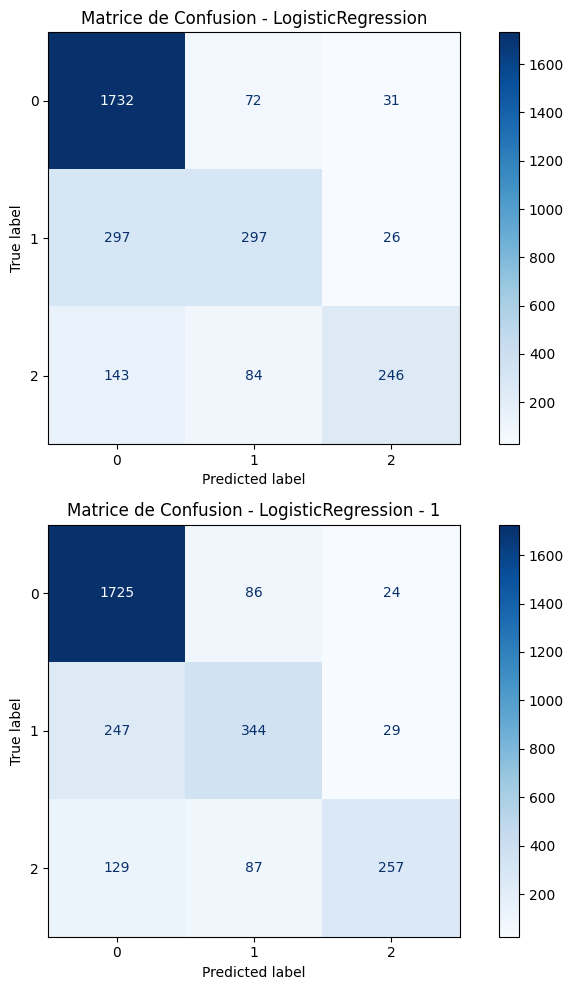

In [19]:
# Prédictions des scores pour chaque modèle
y_preds = {
    "LogisticRegression": model.predict(X_test),
    "LogisticRegression - 1": model_1.predict(X_test_1)
}

fig, axes = plt.subplots(len(y_preds), 1, figsize=(8, 5 * len(y_preds)))  

# S'assurer que axes est une liste même s'il y a un seul modèle
if len(y_preds) == 1:
    axes = [axes]

for row, (model_name, y_pred) in enumerate(y_preds.items()):
    y_true = y_test if "- 1" not in model_name else y_test_1

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(ax=axes[row], cmap=plt.cm.Blues)
    axes[row].set_title(f"Matrice de Confusion - {model_name}")

plt.tight_layout()
plt.show()


## Test du modele NLP : 
### Deux phrases positives : 
- "The flight was smooth, the staff was friendly, and the overall experience was great!"
- "I had an amazing time flying with this airline, everything was punctual and comfortable."
### Deux phrases négatives : 
- "The flight was delayed for hours without any clear communication, and the service was poor."
- "I had a terrible experience, the seats were uncomfortable, and the staff was unhelpful."
### Deux phrases neutres : 
- "The flight was average. Nothing special, but no major issues either."
- "The flight was on time, but there was nothing extraordinary about the service."

In [27]:
# Exemple de phrases à prédire
new_sentences = ["The flight was smooth, the staff was friendly, and the overall experience was great!",
                 "I had an amazing time flying with this airline, everything was punctual and comfortable.", 
                 "The flight was delayed for hours without any clear communication, and the service was poor.",
                 "I had a terrible experience, the seats were uncomfortable, and the staff was unhelpful.",
                 "The flight was average. Nothing special, but no major issues either.",
                 "The flight was on time, but there was nothing extraordinary about the service."]


# Transformer les nouvelles phrases en vecteurs
new_sentences_tfidf = vectorizer.transform(new_sentences)

# Prédire les classes
predictions = model.predict(new_sentences_tfidf)

# Prédire les probabilités 
probabilities = model.predict_proba(new_sentences_tfidf)

# Afficher les résultats
for sentence, label, proba in zip(new_sentences, predictions, probabilities):
    print(f"Phrase : {sentence}")
    print(f"Prédiction : {label}")
    print(f"Probabilités : {proba}\n")

Phrase : The flight was smooth, the staff was friendly, and the overall experience was great!
Prédiction : 2
Probabilités : [0.25709157 0.01620434 0.7267041 ]

Phrase : I had an amazing time flying with this airline, everything was punctual and comfortable.
Prédiction : 2
Probabilités : [0.07259636 0.02191555 0.90548808]

Phrase : The flight was delayed for hours without any clear communication, and the service was poor.
Prédiction : 0
Probabilités : [9.96549907e-01 2.55981718e-03 8.90275798e-04]

Phrase : I had a terrible experience, the seats were uncomfortable, and the staff was unhelpful.
Prédiction : 0
Probabilités : [0.96198541 0.01170737 0.02630722]

Phrase : The flight was average. Nothing special, but no major issues either.
Prédiction : 0
Probabilités : [0.91978742 0.05418275 0.02602982]

Phrase : The flight was on time, but there was nothing extraordinary about the service.
Prédiction : 0
Probabilités : [0.94513896 0.02676919 0.02809185]



In [31]:
new_sentences = [
    "The flight was smooth, the staff was friendly, and the overall experience was great!",
    "I had an amazing time flying with this airline, everything was punctual and comfortable.",
    "The flight was delayed for hours without any clear communication, and the service was poor.",
    "I had a terrible experience, the seats were uncomfortable, and the staff was unhelpful.",
    "The flight was average. Nothing special, but no major issues either.",
    "The flight was on time, but there was nothing extraordinary about the service."
]

# Si vous avez des mots sous forme de liste et souhaitez les joindre en une phrase :
new_sentences = [' '.join(sentence.split()) for sentence in new_sentences]

# Transformer les nouvelles phrases en vecteurs
new_sentences_tfidf = tfidf_vectorizer.transform(new_sentences)

# Prédire les classes
predictions = model_1.predict(new_sentences_tfidf)

# Prédire les probabilités 
probabilities = model_1.predict_proba(new_sentences_tfidf)

# Afficher les résultats
for sentence, label, proba in zip(new_sentences, predictions, probabilities):
    print(f"Phrase : {sentence}")
    print(f"Prédiction : {label}")
    print(f"Probabilités : {proba}\n")

Phrase : The flight was smooth, the staff was friendly, and the overall experience was great!
Prédiction : 2
Probabilités : [0.17833398 0.00930963 0.8123564 ]

Phrase : I had an amazing time flying with this airline, everything was punctual and comfortable.
Prédiction : 2
Probabilités : [0.12639982 0.01590543 0.85769475]

Phrase : The flight was delayed for hours without any clear communication, and the service was poor.
Prédiction : 0
Probabilités : [0.99258477 0.00373243 0.00368279]

Phrase : I had a terrible experience, the seats were uncomfortable, and the staff was unhelpful.
Prédiction : 0
Probabilités : [0.93698973 0.0089961  0.05401417]

Phrase : The flight was average. Nothing special, but no major issues either.
Prédiction : 0
Probabilités : [0.96788603 0.02040218 0.01171179]

Phrase : The flight was on time, but there was nothing extraordinary about the service.
Prédiction : 0
Probabilités : [0.94308782 0.02544854 0.03146364]



# II. Partie LLM : 

#  **Twitter-roBERTa-base pour l’Analyse de Sentiment**  

Le modèle **Twitter-roBERTa-base** est un modèle **RoBERTa-base préentraîné** sur **environ 124 millions de tweets** publiés entre **janvier 2018 et décembre 2021**. Il a ensuite été **affiné** pour l’**analyse de sentiment** à l’aide du **benchmark TweetEval**, ce qui en fait un outil puissant pour comprendre les émotions exprimées sur Twitter.  

🔗 **Source officielle** : [Twitter-roBERTa-base sur Hugging Face](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest#twitter-roberta-base-for-sentiment-analysis---updated-2022)  


In [33]:
#Charger le modèle et le tokenizer Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

c:\Users\DELL\miniconda3\envs\workspace\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DELL\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment-latest. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment

In [36]:
#Fonction pour prédire le sentiment d'un tweet
def predict_sentiment(tweet):
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        logits = model(**inputs).logits
    prediction = torch.argmax(logits, dim=-1).item()

    # Classes de sentiment
    sentiment_labels = ["Négatif", "Neutre", "Positif"]
    return sentiment_labels[prediction]

In [39]:
#  Appliquer la prédiction sur chaque tweet et ajouter les résultats dans le DataFrame
df1['predicted_label'] = [predict_sentiment(tweet) for tweet in tqdm(df1['clean_text_1_1'], desc="Prédiction des sentiments")]

Prédiction des sentiments: 100%|██████████| 14640/14640 [1:07:37<00:00,  3.61it/s]
C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\1231318111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['predicted_label'] = [predict_sentiment(tweet) for tweet in tqdm(df1['clean_text_1_1'], desc="Prédiction des sentiments")]


C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\487842688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["predicted_label_numeric"] = df1["predicted_label"].map(label_mapping)


Rapport de classification :
               precision    recall  f1-score   support

     Négatif       0.93      0.78      0.85      9178
      Neutre       0.53      0.74      0.61      3099
     Positif       0.75      0.81      0.78      2363

    accuracy                           0.78     14640
   macro avg       0.73      0.77      0.75     14640
weighted avg       0.81      0.78      0.79     14640



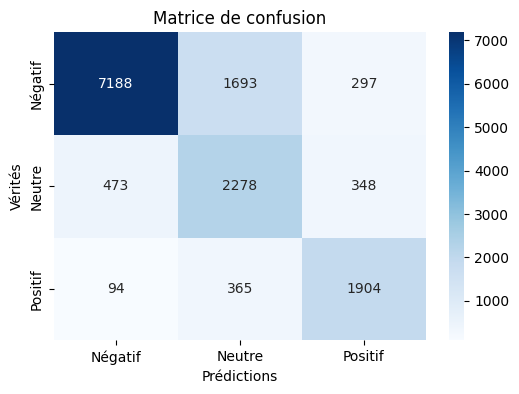

In [45]:
# Mapper les labels prédits en indices numériques
label_mapping = {"Négatif": 0, "Neutre": 1, "Positif": 2}
df1["predicted_label_numeric"] = df1["predicted_label"].map(label_mapping)

# Rapport de classification (précision, rappel, F1-score)
report = classification_report(df1["airline_sentiment"], df1["predicted_label_numeric"], target_names=["Négatif", "Neutre", "Positif"])
print("Rapport de classification :\n", report)

# Matrice de confusion
conf_matrix = confusion_matrix(df1["airline_sentiment"], df1["predicted_label_numeric"])

# Visualiser la matrice de confusion
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Négatif", "Neutre", "Positif"], yticklabels=["Négatif", "Neutre", "Positif"])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion")
plt.show()

## Test du modele LLM (Avec les mêmes phrases): 

In [47]:
new_sentences = [ 
    "The flight was smooth, the staff was friendly, and the overall experience was great!",
    "I had an amazing time flying with this airline, everything was punctual and comfortable.",
    "The flight was delayed for hours without any clear communication, and the service was poor.",
    "I had a terrible experience, the seats were uncomfortable, and the staff was unhelpful.",
    "The flight was average. Nothing special, but no major issues either.",
    "The flight was on time, but there was nothing extraordinary about the service."
]

# Prédictions pour les nouvelles phrases
for sentence in new_sentences:
    sentiment = predict_sentiment(sentence)
    print(f"Phrase : {sentence}")
    print(f"Prédiction : {sentiment}\n")

Phrase : The flight was smooth, the staff was friendly, and the overall experience was great!
Prédiction : Positif

Phrase : I had an amazing time flying with this airline, everything was punctual and comfortable.
Prédiction : Positif

Phrase : The flight was delayed for hours without any clear communication, and the service was poor.
Prédiction : Négatif

Phrase : I had a terrible experience, the seats were uncomfortable, and the staff was unhelpful.
Prédiction : Négatif

Phrase : The flight was average. Nothing special, but no major issues either.
Prédiction : Négatif

Phrase : The flight was on time, but there was nothing extraordinary about the service.
Prédiction : Neutre



#  BERT-Base Multilingual Uncased 

Ce modèle bert-base-multilingual-uncased a été finement ajusté pour l’analyse de sentiment sur des critiques de produits dans six langues : Anglais, Néerlandais, Allemand, Français, Espagnol, et Italien. Il prédit le sentiment d'une critique sous forme de nombre d’étoiles, allant de 1 à 5.
Ce modèle peut être utilisé directement pour l’analyse de sentiment sur les critiques de produits dans l'une des six langues ci-dessus, ou il peut être finement ajusté pour d'autres tâches d’analyse de sentiment similaires. 

Nous avons poser une échelle allant de : ("Très négatif", "Négatif", "Neutre", "Positif", "Très positif") avec :
- "Très négatif" = "Négatif"
- "Très positif" = "Positif"

🔗 **Source officielle** : [BERT-Base Multilingual sur Hugging Face](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)  


In [53]:
# Charger le modèle et le tokenizer Hugging Face
model_name_1 = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer_1 = AutoTokenizer.from_pretrained(model_name_1)
model_1 = AutoModelForSequenceClassification.from_pretrained(model_name_1)

In [54]:
# Classes de sentiment pour ce modèle
sentiment_labels = ["Très négatif", "Négatif", "Neutre", "Positif", "Très positif"]

# Fonction pour prédire le sentiment d'un tweet
def predict_sentiment_1(tweet):
    inputs = tokenizer_1(tweet, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    
    with torch.no_grad():
        logits = model_1(**inputs).logits
    
    prediction = torch.argmax(logits, dim=-1).item()
    
    return sentiment_labels[prediction]  

In [57]:
# Appliquer la prédiction sur chaque tweet et ajouter les résultats dans le DataFrame
tqdm.pandas(desc="Prédiction des sentiments")
df1["predicted_label_1"] = df1["clean_text_1_1"].progress_apply(predict_sentiment_1)

Prédiction des sentiments: 100%|██████████| 14640/14640 [1:10:14<00:00,  3.47it/s]
C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\3829202820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["predicted_label_1"] = df1["clean_text_1_1"].progress_apply(predict_sentiment_1)


C:\Users\DELL\AppData\Local\Temp\ipykernel_13164\2529203775.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["predicted_label_numeric_1"] = df1["predicted_label_1"].map(label_mapping)


Rapport de classification :
               precision    recall  f1-score   support

     Négatif       0.83      0.74      0.78      9178
      Neutre       0.30      0.17      0.22      3099
     Positif       0.41      0.81      0.54      2363

    accuracy                           0.63     14640
   macro avg       0.51      0.58      0.52     14640
weighted avg       0.65      0.63      0.62     14640



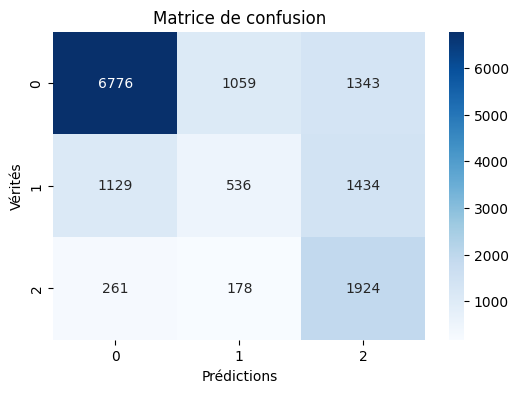

In [61]:
# Mapper les labels prédits en indices numériques (sans modification)
label_mapping = {"Très négatif": 0, "Négatif": 0, "Neutre": 1, "Positif": 2, "Très positif": 2}
df1["predicted_label_numeric_1"] = df1["predicted_label_1"].map(label_mapping)

# Rapport de classification (précision, rappel, F1-score)
report = classification_report(df1["airline_sentiment"], df1["predicted_label_numeric_1"], target_names=["Négatif", "Neutre", "Positif"])
print("Rapport de classification :\n", report)

# Matrice de confusion
conf_matrix = confusion_matrix(df1["airline_sentiment"], df1["predicted_label_numeric_1"])

# Visualiser la matrice de confusion en utilisant les indices numériques 0, 1, 2
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion")
plt.show()

## Test du modele LLM (Avec les mêmes phrases): 

In [62]:
new_sentences = [ 
    "The flight was smooth, the staff was friendly, and the overall experience was great!",
    "I had an amazing time flying with this airline, everything was punctual and comfortable.",
    "The flight was delayed for hours without any clear communication, and the service was poor.",
    "I had a terrible experience, the seats were uncomfortable, and the staff was unhelpful.",
    "The flight was average. Nothing special, but no major issues either.",
    "The flight was on time, but there was nothing extraordinary about the service."
]

# Prédictions pour les nouvelles phrases
for sentence in new_sentences:
    sentiment = predict_sentiment_1(sentence)
    print(f"Phrase : {sentence}")
    print(f"Prédiction : {sentiment}\n")

Phrase : The flight was smooth, the staff was friendly, and the overall experience was great!
Prédiction : Très positif

Phrase : I had an amazing time flying with this airline, everything was punctual and comfortable.
Prédiction : Très positif

Phrase : The flight was delayed for hours without any clear communication, and the service was poor.
Prédiction : Très négatif

Phrase : I had a terrible experience, the seats were uncomfortable, and the staff was unhelpful.
Prédiction : Très négatif

Phrase : The flight was average. Nothing special, but no major issues either.
Prédiction : Neutre

Phrase : The flight was on time, but there was nothing extraordinary about the service.
Prédiction : Neutre

